# Going Deeper - CV
## Segmentation
평가문항|상세기준
------|------
U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

### Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.backend import int_shape
from tensorflow.keras.utils import plot_model

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                    Resize(
                        width=224,
                        height=224
                        )
                    ])

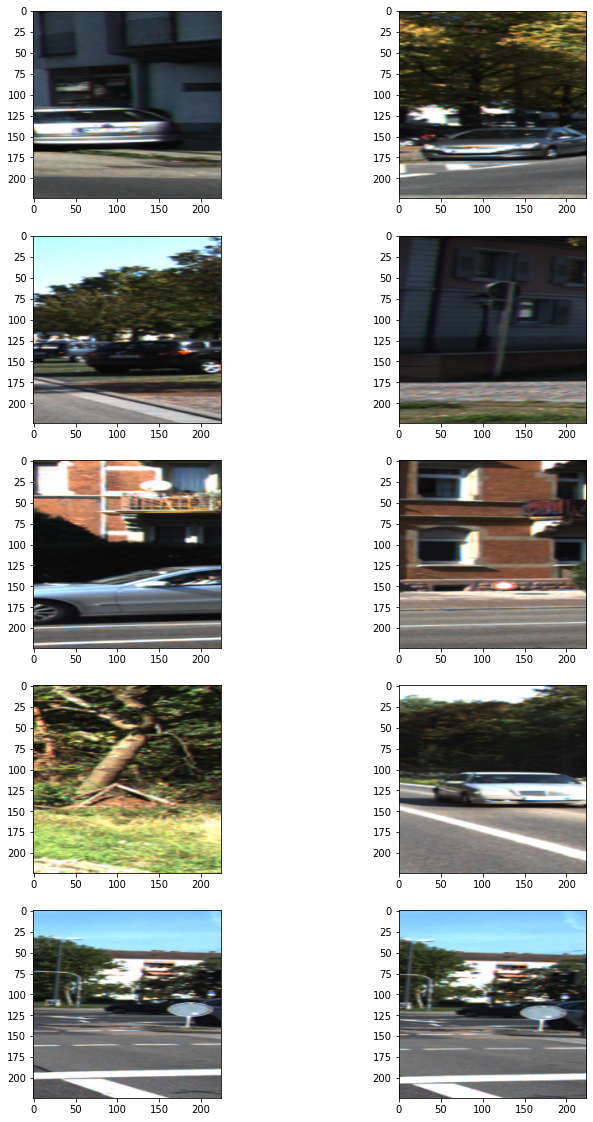

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):

 def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()
 def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
 def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

 def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

 def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False) #only resize
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

In [6]:
def get_crop_layer(target, refer):
    
    target_shape = int_shape(target)
    refer_shape = int_shape(refer)
    # width, the 3rd dimension
    cw = target_shape[2] - refer_shape[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target_shape[1] - refer_shape[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)
    
    crop = Cropping2D(cropping=((ch1,ch2),(cw1,cw2)))(target)

    return crop

In [7]:
def build_origin_model(input_shape=(572,572,3)):
    
    inputs = Input(input_shape)
    
    #contracting 
    conv1 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    conv4 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    conv5 = Conv2D(1024, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv5)
    
    #expanding
    up1 = Conv2DTranspose(512, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv5) #strides 지정 필요!
    crop1 = get_crop_layer(conv4,up1)
    concat1 = concatenate([crop1, up1], axis = 3)
    conv6 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat1)
    conv6 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    
    up2 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    crop2 = get_crop_layer(conv3,up2)
    concat2= concatenate([crop2, up2], axis = 3)
    conv7 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat2)
    conv7 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    
    up3 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    crop3 = get_crop_layer(conv2,up3)
    concat3= concatenate([crop3, up3], axis = 3)
    conv8 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat3)
    conv8 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    
    up4 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    crop4 = get_crop_layer(conv1,up4)
    concat4= concatenate([crop4, up4], axis = 3)
    conv9 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat4)
    conv9 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid', kernel_initializer = 'he_normal')(conv9) #0~1로 조정
    
    model = Model(inputs = inputs, outputs = outputs)
     
    return model

In [8]:
origin_model = build_origin_model()
origin_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
def build_model(input_shape=(224,224,3)):
    
    inputs = Input(input_shape)
    
    #contracting 
    conv1 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    conv4 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    conv5 = Conv2D(1024, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv5)
    
    #expanding
    up1 = Conv2DTranspose(512, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv5) #strides 지정 필요!
    crop1 = get_crop_layer(conv4,up1)
    concat1 = concatenate([crop1, up1], axis = 3)
    conv6 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat1)
    conv6 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    
    up2 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    crop2 = get_crop_layer(conv3,up2)
    concat2= concatenate([crop2, up2], axis = 3)
    conv7 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat2)
    conv7 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    
    up3 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    crop3 = get_crop_layer(conv2,up3)
    concat3= concatenate([crop3, up3], axis = 3)
    conv8 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat3)
    conv8 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    
    up4 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    crop4 = get_crop_layer(conv1,up4)
    concat4= concatenate([crop4, up4], axis = 3)
    conv9 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat4)
    conv9 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid', kernel_initializer = 'he_normal')(conv9) # 0~1로 조정
    
    model = Model(inputs = inputs, outputs = outputs)
     
    return model

In [10]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [11]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit(
     x = train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     verbose = 1
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
11/11 [==============================] - 24s 619ms/step - loss: 0.6884 - val_loss: 0.6689
Epoch 2/100
11/11 [==============================] - 6s 589ms/step - loss: 0.6004 - val_loss: 0.2018
Epoch 3/100
11/11 [==============================] - 6s 583ms/step - loss: 0.0605 - val_loss: 0.0313
Epoch 4/100
11/11 [==============================] - 6s 576ms/step - loss: 0.0304 - val_loss: 0.0259
Epoch 5/100
11/11 [==============================] - 6s 578ms/step - loss: 0.0296 - val_loss: 0.0345
Epoch 6/100
11/11 [==============================] - 6s 578ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 7/100
11/11 [==============================] - 6s 577ms/step - loss: 0.0304 - val_loss: 0.0273
Epoch 8/100
11/11 [==============================] - 6s 575ms/step - loss: 0.0422 - val_loss: 0.0343
Epoch 9/100
11/11 [==============================] - 6s 574ms/step - loss: 0.0314 - val_loss: 0.0254
Epoch 10/100
11/11 [==============================] - 6s 571ms/step - loss: 0.0234 - val_l

11/11 [==============================] - 6s 577ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 82/100
11/11 [==============================] - 6s 576ms/step - loss: 0.0157 - val_loss: 0.0199
Epoch 83/100
11/11 [==============================] - 6s 575ms/step - loss: 0.0169 - val_loss: 0.0199
Epoch 84/100
11/11 [==============================] - 6s 574ms/step - loss: 0.0141 - val_loss: 0.0198
Epoch 85/100
11/11 [==============================] - 6s 574ms/step - loss: 0.0127 - val_loss: 0.0201
Epoch 86/100
11/11 [==============================] - 6s 576ms/step - loss: 0.0118 - val_loss: 0.0234
Epoch 87/100
11/11 [==============================] - 6s 573ms/step - loss: 0.0173 - val_loss: 0.0200
Epoch 88/100
11/11 [==============================] - 6s 573ms/step - loss: 0.0172 - val_loss: 0.0194
Epoch 89/100
11/11 [==============================] - 6s 576ms/step - loss: 0.0158 - val_loss: 0.0227
Epoch 90/100
11/11 [==============================] - 6s 574ms/step - loss: 0.0155 - val_loss: 

OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/semantic_segmentation/data/training/seg_model_unet.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

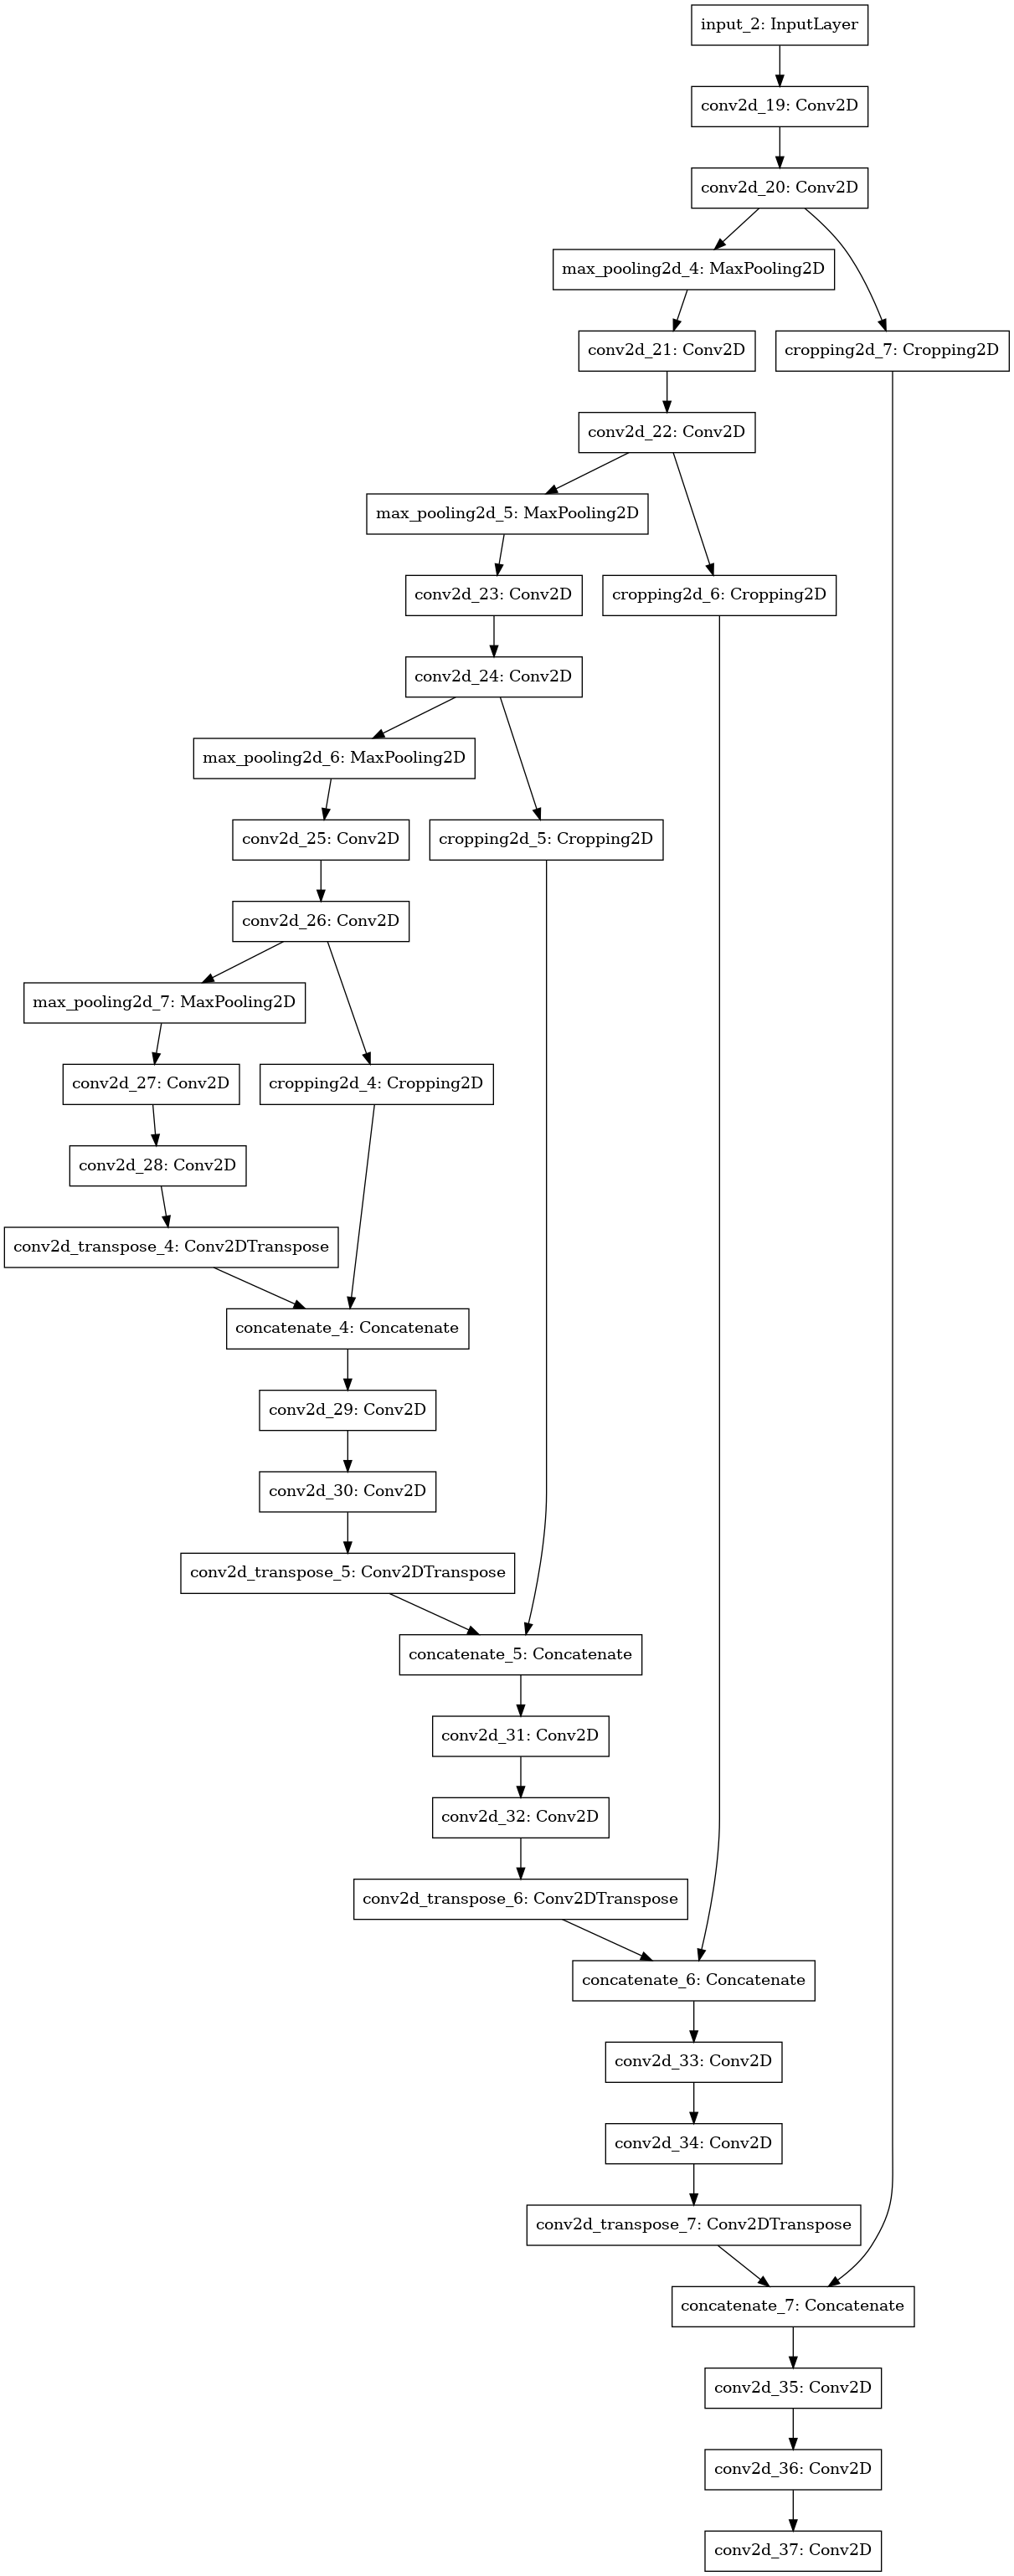

In [12]:
plot_model(model, to_file='model.png')

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

In [13]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
loaded_model = tf.keras.models.load_model(model_path)

OSError: SavedModel file does not exist at: /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5/{saved_model.pbtxt|saved_model.pb}

In [14]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [15]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     loaded_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

NameError: name 'loaded_model' is not defined

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [17]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    display(output)   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [18]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     loaded_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

NameError: name 'loaded_model' is not defined

In [19]:
def build_nested_model(input_shape=(224,224,3), deep_supervision=True, batch_size = 4):
    
    inputs = Input(input_shape)
    
    #Backbone
    conv0_0 = Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv0_0 = Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    
    conv1_0 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool0_0)
    conv1_0 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    conv2_0 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool1_0)
    conv2_0 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    conv3_0 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool2_0)
    conv3_0 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    conv4_0 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool3_0)
    conv4_0 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    
    #대각 layer    
    # 첫번째   
    # X0,1
    up1_0 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_0)
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    
    # X1,1
    up2_0 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv2_0)
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    
    # X2,1
    up3_0 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv3_0)
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    
    # X3,1
    up4_0 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv4_0)
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    #두번째
    # X0,2
    up1_1 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_1)
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    
    # X1,2
    up2_1 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv2_1)
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    
    # X2,2
    up3_1 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv3_1)
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    
    #세번째
    # X0,3
    up1_2 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_2)
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    #네번째
    # X0,4
    up1_3 = Conv2D(32, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)

    #deep_supervision
    output1 = Conv2D(1, 1, activation='sigmoid', name = 'output1')(conv0_1)
    output2 = Conv2D(1, 1, activation='sigmoid', name = 'output2')(conv0_2)
    output3 = Conv2D(1, 1, activation='sigmoid', name = 'output3')(conv0_3)
    output4 = Conv2D(1, 1, activation='sigmoid', name = 'output4')(conv0_4)
    
    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output1,
                                               output2,
                                               output3,
                                               output4])
    else:
        model = Model(inputs = inputs, outputs=output4)

    return model

In [20]:
unet_pp_ds = build_nested_model(deep_supervision=True)
unet_pp_ds.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [21]:
unet_pp = build_nested_model(deep_supervision=False)
unet_pp.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 224, 224, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_70[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_71[0][0]                  
____________________________________________________________________________________________

In [22]:
unet_pp.compile(optimizer = Adam(lr = 3e-4), loss = 'binary_crossentropy')
unet_pp.fit(
     x=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
11/11 [==============================] - 22s 698ms/step - loss: 0.6326 - val_loss: 0.3258
Epoch 2/100
11/11 [==============================] - 7s 645ms/step - loss: 0.1229 - val_loss: 0.0358
Epoch 3/100
11/11 [==============================] - 7s 645ms/step - loss: 0.0358 - val_loss: 0.0339
Epoch 4/100
11/11 [==============================] - 7s 646ms/step - loss: 0.0328 - val_loss: 0.0312
Epoch 5/100
11/11 [==============================] - 7s 644ms/step - loss: 0.0286 - val_loss: 0.0365
Epoch 6/100
11/11 [==============================] - 7s 639ms/step - loss: 0.0407 - val_loss: 0.0358
Epoch 7/100
 2/11 [====>.........................] - ETA: 5s - loss: 0.0258

KeyboardInterrupt: 

In [ ]:
unet_pp_path = '/seg_model_unet_pp.h5'
unet_pp.save(unet_pp_path)

In [ ]:
unet_pp = tf.keras.models.load_model(unet_pp_path)

In [ ]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

In [ ]:
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
unet_iou = []
unet_pp_iou = []

for i in range(25):  # 이미지 25개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output(
         loaded_model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output(
         unet_pp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_pp_iou.append(calculate_iou(target, prediction))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(unet_pp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()